## NLP: Homework 2 Prime

### Patricia Goresen

#### 2/4/2019

In [14]:
import nltk
import urllib.request as urllib2
from bs4 import BeautifulSoup
import string
from lexical_diversity import lex_div as ld
import pandas as pd

### Load Books

In [2]:
def scrape_books():
    book_list = {}
    # get home url
    base_url = "http://www.gutenberg.org/wiki/Children%27s_Instructional_Books_(Bookshelf)"
    # fetch page
    webpage = urllib2.urlopen(base_url)
    # create soup object
    soup = BeautifulSoup(webpage, "html.parser")
    # filter soup object
    uls = [x for x in soup.findChildren("a") if "ebook" in str(x)]
    for link in uls:
        book_list["".join(link.contents)] = "http:" + link.get('href')
    # now we want to get link to books
    for title,url in book_list.items():  
        #print(title)
        #print(url)
        webpage = urllib2.urlopen(url)
        soup = BeautifulSoup(webpage, "html.parser")
        books = soup.find_all("a")
        for i,link in enumerate(books):
            #need link with read this book...
            if "Read this book online" in str(link.contents):
                book_list[title] = "http:" + link.get('href')
    return book_list

In [3]:
all_books = {}
all_books = scrape_books()

In [4]:
#Make sure pulled all books
len(all_books)

104

In [5]:
def cleanText(link):
    webpage = urllib2.urlopen(link).read()
    soup = BeautifulSoup(webpage, 'html.parser')
    book = soup.getText(strip = True)
    # Delete HTML Tags
    book = BeautifulSoup(book, "lxml").text
    #start and stop
    ## The target start position is the table of contents however, not all books have a table of contents
    ### If contents is not found, then introduction is used, then preface, then start of ebook tag
    ### everything before start position is thrown out, so licensing will not be included
    if book.find("CONTENTS") > -1: #if contents is found then....
        beginning = book.find("CONTENTS") + 1 # one index is added so it doesnt include the word contents
    elif book.find("INTRODUCTION") > -1:
        beginning = book.find("INTRODUCTION") + 1
    elif book.find("PREFACE")
        beginning = book.find("PREFACE") + 1
    else:
        beginning = book.find("START OF ") + 4 # four index is added so it doesnt include start of ebook tag
    end = book.find("End of the Project Gutenberg EBook") - 30 # 30 index is subtracted because it's tagged twice
    book = book[beginning:end] #gets rid of everything before start and everything after book ends
    #Convert to lower case
    book = book.lower()
    #replace special characters with space
    book = book.replace('\r', ' ').replace('\n', ' ').replace("," , " ").replace(".", " ").replace("!", " ").replace('"', " ").replace("—", " ").replace("-", " ")
    #Delete page numbers and other characters
    book = "".join([x for x in book if 96 < ord(x) < 123 or ord(x) == 32])    
    #split on spaces
    book = book.split(" ")
    return book

In [6]:
# pull cleaned books
for title,link in all_books.items():
    all_books[title] = cleanText(link)

In [7]:
#Clean up Titles
for key,value in all_books.items():
    if key.find("\n") > -1:
        clean = key.replace('\n', " ")
        all_books[clean]= value
        all_books.pop(key, None)

In [9]:
def vocabMeasures(book, stat):
    if stat == 'token':
        token = len(book)
        return token
    elif stat == 'vocab':
        vocab = len(set(book))
        return vocab
    elif stat == 'long_num':
        words = set(book)
        long_words = [w for w in words if len(w) > 10]
        numLongWords = len(long_words)
        return numLongWords
    elif stat == 'lex_div':
        lex_div = len(set(book)) / len(book)
        return lex_div
    elif stat == 'ttr':
        ttr = ld.ttr(book)
        return ttr
    else:
        mtld = ld.mtld(book)
        return mtld

## 1. In Python, create a method for scoring the vocabulary size of a text, and normalize the score from 0 to 1. It does not matter what method you use for normalization as long as you explain it in a short paragraph. (Various methods will be discussed in the live session.)

The vocabulary size of a text is the count of *unique* words in a text, or the unique set of tokens in a text. The vocabulary size of the Gutenburg books were normalized using the following equation:
$$
 \frac{(x- minX)}{(maxX - minX)}
$$
where x is the vocabulary size of the book, minX is the smallest vocabulary size of all books in the set, and maxX is the biggest vocabulary size of all books. Normalization is used when to adjust a broad range of values to a common scale. This specific normalization method was used because this ensures the range will be [0,1] where 0 will be the smallest value and 1 will be the largest value. Additionally, every value will be scaled according to the min and max. This makes the values scale and more intuitive. This method of normalization is one of the most widely used.

In [10]:
vocabStats = {}
for k,v in all_books.items():
    vocabStats[k] = vocabMeasures(v, 'vocab') 

In [11]:
normVocabStats = {}
maxVocab = max(vocabStats.values())
minVocab = min(vocabStats.values())
normVocabStats = {k: (v-minVocab) / (maxVocab-minVocab) for k, v in vocabStats.items()}

In [73]:
for key, value in sorted(normVocabStats.items(), key=lambda x: x[1]): 
    print("{} : {}".format(key, value))

The Story of Glass : 0.0
Orthography; As Outlined in the State Course of Study for Illinois : 0.0026731319159517593
Little Present : 0.011500683824443615
Book about Animals : 0.023623026233992293
The Flag of My Country. Shikéyah Bidah Na'at'a'í; Navajo New World Readers 2 : 0.030772099962700486
The Flag of My Country. Shikéyah Bidah Na'at'a'í Navajo New World Readers 2 : 0.030772099962700486
Child's Book of Water Birds : 0.053835633470098225
A Primary Reader:  Old-time Stories, Fairy Tales and Myths Retold by Children : 0.054208628621161256
New National First Reader : 0.06061171204774338
A Little Book for A Little Cook : 0.07366654233494964
Boy Blue and his friends, School ed. : 0.07696133283600647
The Bird-Woman of the Lewis and Clark Expedition : 0.08112644535621037
McGuffey's First Eclectic Reader, Revised Edition : 0.08199676737535745
The History of Insects : 0.08976749968917071
Gems of Poetry for Boys and Girls : 0.08995399726470223
Children's Classics in Dramatic Form Book Two : 

In [54]:
#convert to df
normVocabDF = pd.DataFrame(sorted(normVocabStats.items(), key=lambda x: x[1]), columns=['Title', 'NormalizedVocabScore'])
normVocabDF2 = pd.concat([normVocabDF.head(10), normVocabDF.tail(10)])
#normVocabDF2

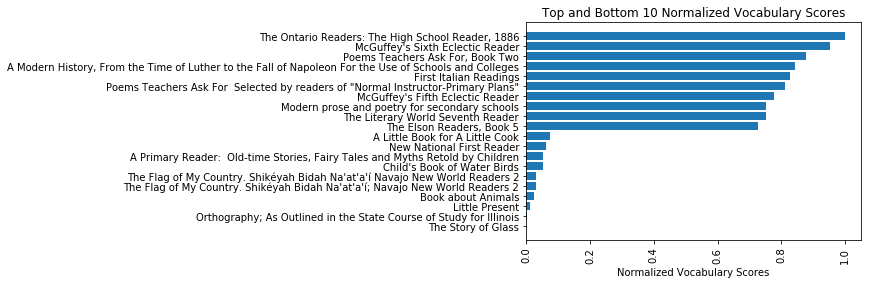

In [56]:
import matplotlib.pyplot as plt
plt.barh(normVocabDF2['Title'], normVocabDF2['NormalizedVocabScore'])
plt.xticks(rotation=90)
plt.xlabel('Normalized Vocabulary Scores')
plt.title('Top and Bottom 10 Normalized Vocabulary Scores')
plt.show()

The vocabulary score results are not very surprising. The distibution between the highest and lowest scores are as expected. The highest score is The Ontario Readers: The High School Reader, 1886 book and the lowest is The Story of Glass. The lowest seem to be elementary school level books. The higher scores seem to be higher level books. The one exception is First Italian Readings, but this is expected as it is introduction a lot of new words.

## 2. After consulting section 3.2 in chapter 1 of Bird-Klein, create a method for scoring the long-word vocabulary size of a text, and likewise normalize (and explain) the scoring as in step 1 above.

The long-word vocabulary size is defined as the number of unique words over a certain length threshold. Expressed in mathematical terms it follows the following condition:
$$
{w | w ∈ V & P(w)}
$$
For this example, we will use p(w) = len(w) > 10. The score will then be normalized using the following equation:

>$$
 f(x) =\ \ \ \  0 <= \frac{(x- minX)}{(maxX - minX)} <= 1
$$
 
The same normalization technique was used. This is to ensure a consistent scaling and interpretation.

In [57]:
longWordsStats = {}
for k,v in all_books.items():
    longWordsStats[k] = vocabMeasures(v, 'long_num') 

In [58]:
normLongStats = {}
maxLong = max(longWordsStats.values())
minLong = min(longWordsStats.values())
normLongStats = {k: (v-minLong) / (maxLong-minLong) for k, v in longWordsStats.items()}

In [59]:
for key, value in sorted(normLongStats.items(), key=lambda x: x[1]): 
    print("{} : {}".format(key, value))

The Story of Glass : 0.0
Little Present : 0.0025786487880350697
Book about Animals : 0.0046415678184631255
Boy Blue and his friends, School ed. : 0.008767405879319236
Orthography; As Outlined in the State Course of Study for Illinois : 0.010314595152140279
The Bird-Woman of the Lewis and Clark Expedition : 0.022692109334708613
The Flag of My Country. Shikéyah Bidah Na'at'a'í; Navajo New World Readers 2 : 0.025786487880350695
The Flag of My Country. Shikéyah Bidah Na'at'a'í Navajo New World Readers 2 : 0.025786487880350695
Among the Farmyard People : 0.026817947395564725
Harry's Ladder to Learning : 0.032490974729241874
Child's Book of Water Birds : 0.03300670448684889
McGuffey's Third Eclectic Reader : 0.040226921093347086
A Primary Reader:  Old-time Stories, Fairy Tales and Myths Retold by Children : 0.0407426508509541
Gems of Poetry for Boys and Girls : 0.042805569881382156
The Little Lame Prince; Rewritten for Young Readers by Margaret Waters : 0.042805569881382156
A Little Book for

In [60]:
#get top & bottom ten values
normLWDf = pd.DataFrame(sorted(normLongStats.items(), key=lambda x: x[1]), columns=['Title', 'NormLongStats'])
normLWDF2 = pd.concat([normLWDf.head(10), normLWDf.tail(10)])

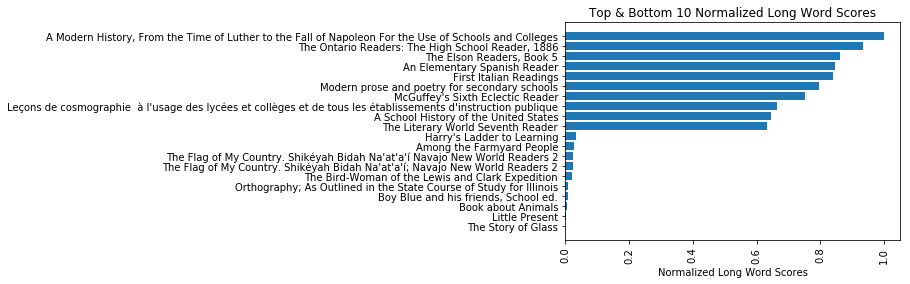

In [61]:
plt.barh(normLWDF2['Title'], normLWDF2['NormLongStats'])
plt.xticks(rotation=90)
plt.xlabel('Normalized Long Word Scores')
plt.title('Top & Bottom 10 Normalized Long Word Scores')
plt.show()

The results of the long-word vocabulary size are somewhat surprising at first glance. In the top ten scores, there seems to be quite a few higher level books. However, there are also a lot of lower level introduction to different languages books. This may be because these specific languages tend to generally have longer words than English. So this metric would be skewed in those language's favors. The lower scores seem to be lower level books.

## 3. Now create a “text difficulty score” by combining the lexical diversity score from homework 1, and your normalized score of vocabulary size and long-word vocabulary size, in equal weighting. Explain what you see when this score is applied to same graded texts you used in homework 1.

In [64]:
lexDivStats = {}
for k,v in all_books.items():
    lexDivStats[k] = vocabMeasures(v, 'lex_div')

In [65]:
#normalize Lexical Diversity
normLexDiv = {}
maxLexDiv = max(lexDivStats.values())
minLexDiv = min(lexDivStats.values())
normLexDiv = {k: (v-minLexDiv) / (maxLexDiv-minLexDiv) for k, v in lexDivStats.items()}

In [66]:
diff_score = dict((k, float((1/3)*normLexDiv[k]) + (1/3)* normLongStats[k] + (1/3)*normVocabStats[k]) for k in normVocabStats)

In [67]:
for key, value in sorted(diff_score.items(), key=lambda x: x[1]): 
    print("{} : {}".format(key, value))

Boy Blue and his friends, School ed. : 0.04571339486056319
A Primary Reader:  Old-time Stories, Fairy Tales and Myths Retold by Children : 0.05738066632278254
The Bird-Woman of the Lewis and Clark Expedition : 0.06535644393953075
McGuffey's First Eclectic Reader, Revised Edition : 0.07189236067349822
New National First Reader : 0.07362328659154806
Among the Farmyard People : 0.0778740494253527
Child's Book of Water Birds : 0.08230248665090806
The Book of Nature Myths : 0.0824473890416969
Wildflowers of the Farm : 0.09201909528448958
Children's Classics in Dramatic Form Book Two : 0.09221338167111051
A Little Book for A Little Cook : 0.09347584734749598
The Little Lame Prince; Rewritten for Young Readers by Margaret Waters : 0.09688927245236244
Story Hour Readers — Book Three : 0.09908624127424959
The Boy Mechanic: Volume 1 700 Things for Boys to Do : 0.09950362293276538
The History of Insects : 0.1025939322555856
Orthography; As Outlined in the State Course of Study for Illinois : 0.10

In [68]:
#get top & bottom ten values
normDiffDF = pd.DataFrame(sorted(diff_score.items(), key=lambda x: x[1]), columns=['Title', 'NormDiffScore'])
normDiffDF2 = pd.concat([normDiffDF.head(10), normDiffDF.tail(10)])

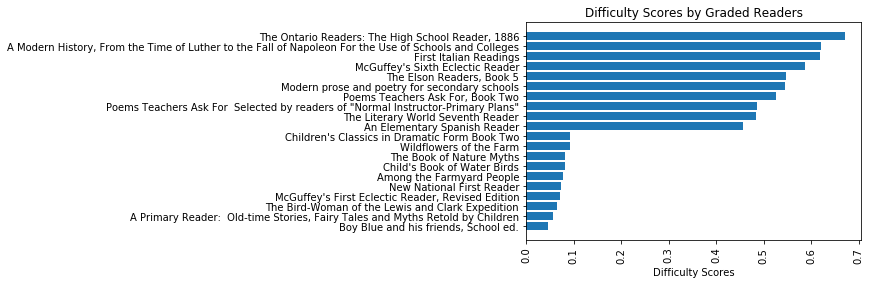

In [69]:
plt.barh(normDiffDF2['Title'], normDiffDF2['NormDiffScore'])
plt.xticks(rotation=90)
plt.xlabel('Difficulty Scores')
plt.title('Difficulty Scores by Graded Readers')
plt.show()

The difficulty score seems to behave the most intuitively overall. All of the higher scores correspond to upper level books. The lower scores seem to be lower level books. The difficulty score seems to accurately measure the book's difficulty level the best out of the other measures.